# First steps to simulating a non-linear sigma model with topological charge
Start by looking at the 2D O(3) non-linear sigma model using complex Langevin. This model should not require CL as it doesn't have a sign problem, but once we introduce an additional non-zero theta term, we will need this formulation

## Progress log

### Old

Thurs, Sept 22
* programmed the class fields
    * initializes the lattice with 3-component random unit vectors (need to make these 0s and 1s...)
    * loops over all 8 triangles at each vertex CCW
    * calculates Q 
    * calculates A
    * calculates the action
    * checks that all values of Q fall between -1/2 and 1/2
* outstanding questions:
    * how to do the MC evolution -- they did analytic continuation of $\theta$ to from real to imaginary
    * can I do CL in python???

Tues, Sept 27
* trying to figure out how to get access to scratch...
* attempting CL in python
    * started some notes
    * will likely need to rewrite the whole class to handle the extra fields

Tues, November 8
* definitely need to figure out the MC piece of this
* goal: do the simulation of the part without a sign problem
* questions:
    - Should the spins be a 1 in one direction and a 0 in the others?
    - How do we "flip" a spin? (Maybe I should look at the potts model again) 
        * I ended up doing a change spin fucntion that generates a totally random new spin
    - Instead of drawing a random number between 0 and 1, should I have the metropolis accept step be min(1,dS)? See this ref: https://mc-stan.org/docs/2_19/reference-manual/hamiltonian-monte-carlo.html
 * consider adding a checkpoint and restart option

Fri Nov 9
* add checkpoint and restart option

Tue Jan 31
* Added to github
* rearranged structure so data (configurations for checkpoints) is stored separately from the github repo

### Recent

9/20/23
* Changed ```random_spin``` to be properly distributed
* Checked distribution

## The physics/math

$S = \frac{1}{2g} \int d^{2} x \left( \partial_{\mu} \vec{\phi}(x)\right)^{2} - i \theta \int d^{2} x Q(x)$

with

$Q(x) = \frac{1}{8 \pi} \epsilon^{\mu \nu} \epsilon_{abc} \partial_{\mu} \phi^{b}(x) \partial_{\nu}\phi^{c}(x)$

with $\phi$ a 3-component unit vector.

In lattice action form, we have (see B. Alles, M. Giordano, and A. Papa. Behavior near θ = π of the mass gap in the two-dimensional o(3) nonlinear sigma model. Phys. Rev. B, 90:184421, Nov 2014):

$
\begin{eqnarray}
S_{L} &=& A_{L} - i \theta Q_{L}\\
A_{L} &=& -\frac{1}{g_{L}}\sum_{x,\mu}\left(\phi_{x}\cdot \phi_{x+\hat{\mu}}\right)\\
Q_{L} &=& \sum_{x}\sum_{\Delta} Q_{L} \Delta
\end{eqnarray}
$

where $\vec{\phi}$ a 3-component unit vector ($\vec{\phi} \cdot\vec{\phi} = 1$) and $Q_{L}$ is the total topological charge on the lattice. The topological charge has been defined via sums over triangles created by cutting each square plaquette along the diagonal. Each vertex is labeled (numbered counter-clockwise), such that we call the fields at the sites of the vertices $\vec{\phi}_{1}$, $\vec{\phi}_{2}$, and $\vec{\phi}_{3}$. We perform the sums over all triangles on the lattice:

### Regularization of the topological charge

Each plaquette is cut through on the diagonal and turned into two triangles. We calculate the topological charge over each triangle, which obeys

$\exp(2 \pi i Q_{L}(\Delta)) = \frac{1}{\rho}\left(1 + \vec{\phi}_{1}\cdot\vec{\phi}_{2} + \vec{\phi}_{2}\cdot\vec{\phi}_{3} + \vec{\phi}_{3}\cdot\vec{\phi}_{1} + i \vec{\phi}_{1} \cdot (\vec{\phi}_{2}\times\vec{\phi}_{3})\right)$

with 

$\rho^{2} = 2(1+\vec{\phi}_{1}\cdot\vec{\phi}_{2})(1 + \vec{\phi}_{2}\cdot\vec{\phi}_{3})(1+ \vec{\phi}_{3}\cdot\vec{\phi}_{1})$ 

and 

$Q_{L}(\Delta) \in \left[-\frac{1}{2}, \frac{1}{2}\right]$

When we sum over all triangles, the total topological charge should provide integer values.

# Python code
try this in Python first and see what you can do. You will need to convert it to C++ though.

### Lattice class
Defined the fields class in an external python doc. Import that here.

In [1]:
import numpy as np
import os
from lattice import *

### Checking spin distribution

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
L = fields(Nx = 2,Ny = 2,theta = 0.0,gL = 1,n_eq = 100, n_MC = 100)

In [4]:
df = pd.DataFrame()
for n in range(5000):
    s = L.random_spin()
    data = pd.Series({'phi_x': s[0],'phi_y':s[1], 'phi_z': s[2]})
    df = pd.concat([df, data.to_frame().T])

In [5]:
df.head()

,phi_x,phi_y,phi_z
0,-0.143298,0.893959,-0.424621
0,0.281805,-0.916568,-0.283706
0,-0.109580,-0.681932,-0.723160
0,-0.778792,-0.565528,-0.271405
0,-0.787344,-0.555685,0.267027


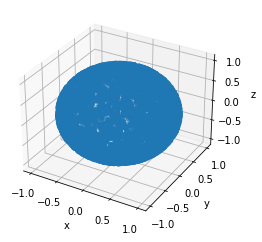

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

phi_plot_data = df[df.index % 3 == 0]
x = phi_plot_data['phi_x']
y = phi_plot_data['phi_y']
z = phi_plot_data['phi_z']

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(x, y, z)

plt.show()

### Testing QL

In [7]:
#set parameters
L_ref = 180
L_test = 10
gL_ref = 1./1.6
gL_test = gL_ref
theta_test = 0.0
nMC = 10
ntherm = 0

#initialize
L = fields(Nx = L_test,Ny = L_test, theta = theta_test, gL = gL_test,n_eq = ntherm, n_MC = nMC, freq = 10)
L.initialize_lattice()
L.equilibrate()

In [8]:
#test QL
QLcos, Qcos_err, QLsin, Qsin_err = L.check_Q()

Computing Q_L with arccos:
No values of Q fall outside of -1/2 and 1/2!
Q_L is a non-integer value: -0.3640278307017348
Computing Q_L with arcsin:
No values of Q fall outside of -1/2 and 1/2!
Q_L is a non-integer value: 1.9341755688158628
Q takes on different values if solved with arcsin v arccos. Arccos = -0.3640278307017348, arcsin = 1.9341755688158628


### Initialization

In [9]:
checkpoint_folder = os.getcwd()+"../Checkpoints/"

In [10]:
L = fields(Nx = 2,Ny = 2,theta = 0.0,gL = 1,n_eq = 100, n_MC = 100)
L.initialize_lattice()
saved_L = L.representation
L.initialize_lattice(config = saved_L)
print([i==j for i,j in zip(L.representation, saved_L)])

[array([[ True,  True,  True],
       [ True,  True,  True]]), array([[ True,  True,  True],
       [ True,  True,  True]])]


## QMC for $\theta = 0$

In [11]:
#set parameters
L_ref = 180
L_test = 10
gL_ref = 1./1.6
gL_test = gL_ref
theta_test = 0.0
nMC = 100
ntherm = 0

### Checkpointed

In [12]:
'''
# import a checkpoint
cfgs = np.loadtxt(checkpoint_folder+"mc_configs_0-99.csv",delimiter = ',',dtype = float)
last_cfg = cfgs[-1,:]
last_cfg = np.reshape(last_cfg,[180,180,3])
L = fields(Nx = L_ref,Ny = L_test, theta = theta_test, gL = gL_test,n_eq = ntherm, n_MC = nMC)
L.initialize_lattice(checkpoint = True, config = last_cfg)
'''

'\n# import a checkpoint\ncfgs = np.loadtxt(checkpoint_folder+"mc_configs_0-99.csv",delimiter = \',\',dtype = float)\nlast_cfg = cfgs[-1,:]\nlast_cfg = np.reshape(last_cfg,[180,180,3])\nL = fields(Nx = L_ref,Ny = L_test, theta = theta_test, gL = gL_test,n_eq = ntherm, n_MC = nMC)\nL.initialize_lattice(checkpoint = True, config = last_cfg)\n'

### Not checkpointed

In [13]:
L = fields(Nx = L_test,Ny = L_test, theta = theta_test, gL = gL_test,n_eq = ntherm, n_MC = nMC, freq = 100)
L.initialize_lattice(config = saved_L)
L.equilibrate()

In [14]:
mc_configs, mc_S, mc_Q = L.Metropolis()

MC iteration 0 complete


### Visualization

In [15]:
#configs_out = [i.flatten() for i in mc_configs]
#np.savetxt(checkpoint_folder+"mc_configs_100-199.csv",configs_out, delimiter=",")

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

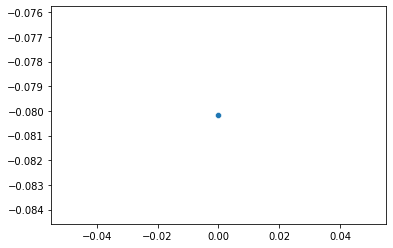

In [17]:
sns.scatterplot(x = np.arange(0,len(mc_Q),1),y = mc_Q)
#plt.ylim(np.min(mc_S)-0.1,np.max(mc_S)+0.1)
plt.show()

In [18]:
mc_configs = np.array(mc_configs)
configs_x = mc_configs[:,:,:,0]

IndexError: index 1 is out of bounds for axis 0 with size 1

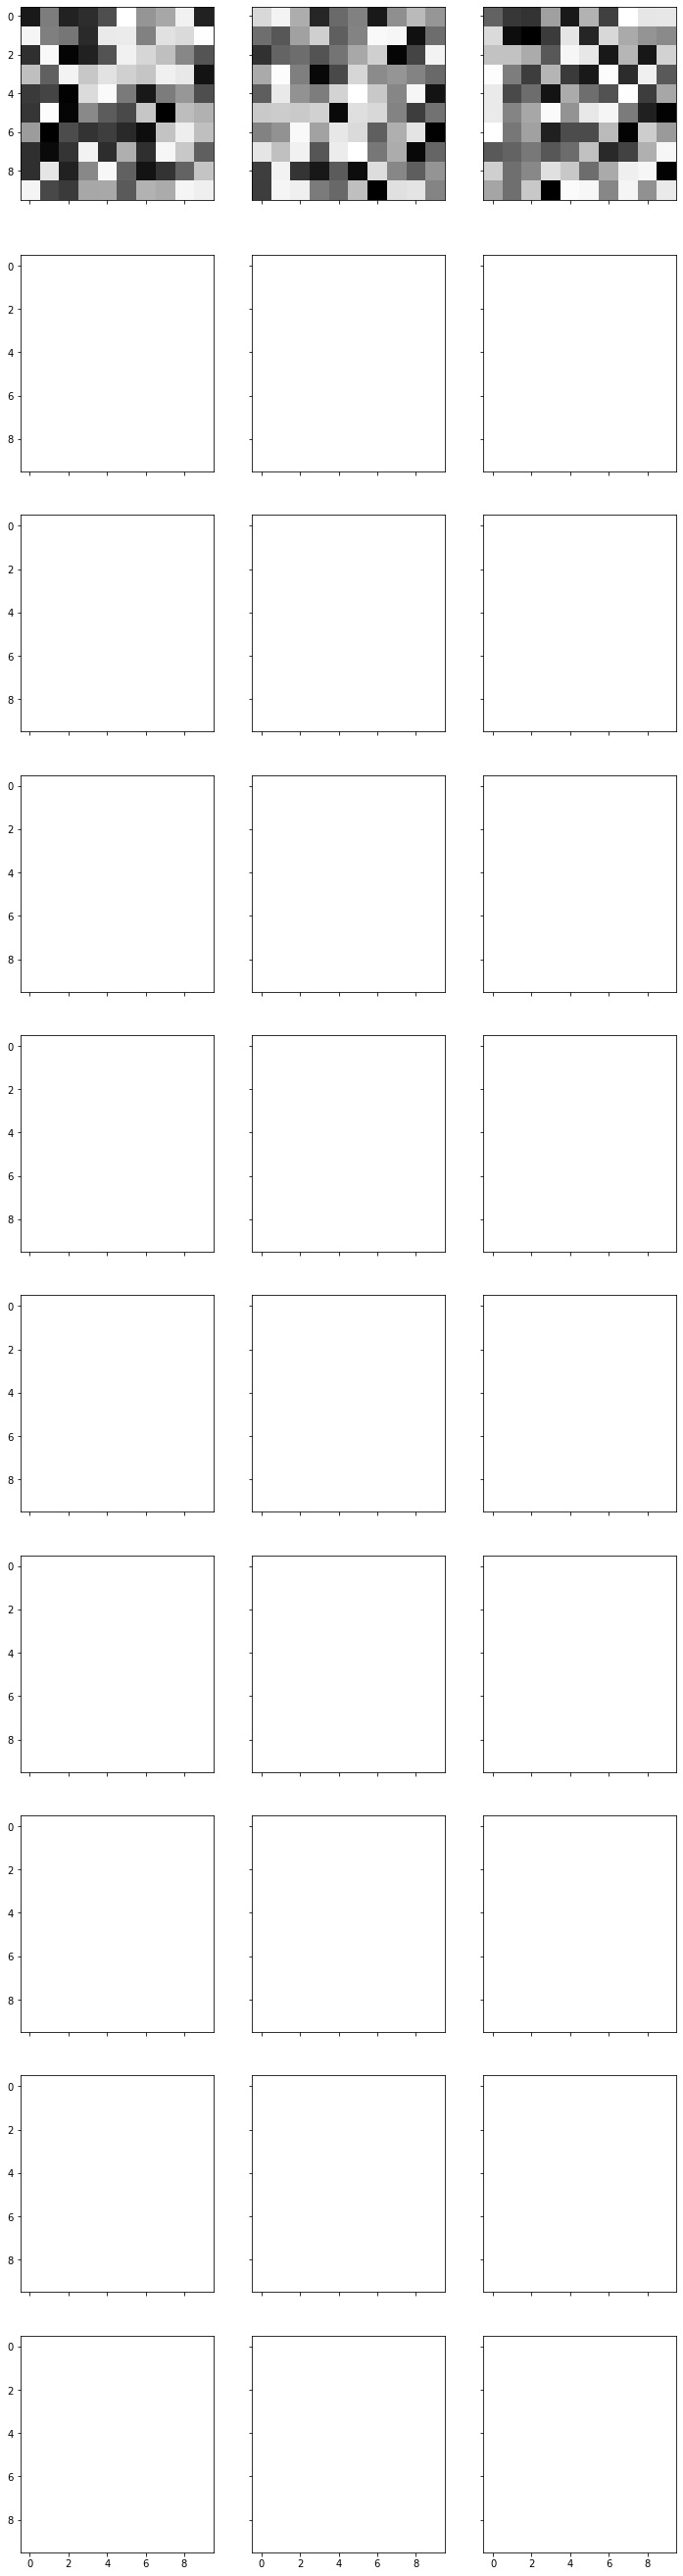

In [19]:
fig, axes = plt.subplots(10, 3, figsize = (12,48),sharex=True, sharey=True)
for i in range(10):
    for j in range(3):
        axes[i,j].imshow(mc_configs[i,:,:,j],cmap = "Greys")
plt.tight_layout()
plt.show()

# Complex Langevin

In this case, I believe the fields are already real. Which means we don't need to express the complex scalar fields as real fields first. That part is already done.

What remains is to complexify the real fields and evolve them via CL.

$\phi_{a} \rightarrow \phi_{a}^{R} + i \phi_{a}^{I}$ (will you have a missing factor of $\sqrt{2}$?)

You probably need to rewrite your class to manage this. You don't want complex numbers popping up anywhere -- you need the complexified fields to hold all of that.

Try this soon...

# Getting access to scratch

In [ ]:
import os

In [ ]:
os.getcwd()

In [ ]:
path = '/Users/cberger/scratch/bergerlab'

In [ ]:
os.listdir(path)

Problem -- I can't access my research storage from JupyterHub